<a href="https://colab.research.google.com/github/Kentaro-Kamaishi/AICompositionSupport/blob/main/model_depth_first.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/KentaroKamaishi/Music-VAE/notebooks'

/content/drive/MyDrive/KentaroKamaishi/Music-VAE/notebooks


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import sys
#sys.path.insert(0,'../src/')
sys.path.insert(0,'/content/drive/MyDrive/KentaroKamaishi/Music-VAE/src/')

In [ ]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 5.9 MB/s 
     |████████████████████████████████| 51 kB 8.1 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=b86688f094b9d1017839cdc2bf6b1e6c46527ca990e80cb69ca437540f832a59
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [ ]:
from data.dataloader import MidiDataset
from data.bar_transform import BarTransform
from torch.utils.data import Dataset, dataloader

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
from midi_builder import MidiBuilder

import pretty_midi as pm
from torch import optim

In [ ]:
builder = MidiBuilder()

cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')

params = {}
params['NOTESPERBAR'] = 16

params['totalbars'] = 8
params['NUM_PITCHES'] = 60+1

params['TOTAL_NOTES'] = params['NOTESPERBAR']*params['totalbars']

params['batch_size'] = 512

params['enc_h_dim'] = 256
params['latent_dim'] = 128
params['cond_h_dim'] = 256
params['dec_h_dim'] = 64

In [ ]:
my_dir = '/content/drive/MyDrive/KentaroKamaishi/Music-VAE/'
# totalbars個ずつに区切る
transform = BarTransform(bars=params['totalbars'], note_count=params['NUM_PITCHES'])
midi_dataset = MidiDataset(csv_file=my_dir+'piano_rolls_small.csv', transform=transform)

random_seed = 42

valid_split = .1
test_split = .1
shuffle = True

if random_seed is not None:
    np.random.seed(random_seed)

dataset_size = len(midi_dataset)
valid_size = int(valid_split * dataset_size)
test_size = int(test_split*dataset_size)
train_size = dataset_size-test_size-valid_size

train_dataset, valid_dataset, test_dataset = random_split(midi_dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=shuffle, batch_size=params['batch_size'])
valid_loader = DataLoader(valid_dataset, shuffle=shuffle, batch_size=params['batch_size'])
test_loader = DataLoader(test_dataset, shuffle=shuffle, batch_size=params['batch_size'])

print('Train size:{}, Valid size:{}, Test size:{}'.format(train_size, valid_size, test_size))

Train size:7776, Valid size:971, Test size:971


In [ ]:
class MusicVAE(nn.Module):
    def __init__(self, params, device):
        super(MusicVAE, self).__init__()
        self.num_pitches = params['NUM_PITCHES'] #音符1つの次元
        enc_h_dim = params['enc_h_dim'] #隠れ層の次元
        latent_dim = params['latent_dim']
        cond_h_dim = params['cond_h_dim']
        self.cond_h_dim = cond_h_dim
        dec_h_dim = params['dec_h_dim']
        self.bs = 0 # batch_size
        self.dec_h_dim = dec_h_dim
        self.subseq_len = params['NOTESPERBAR'] #1小節(単位:16分音符)
        self.device = device
        self.eps_i = 1

        self.enc_lstm = nn.LSTM(self.num_pitches, enc_h_dim, batch_first=True, bidirectional=True)
        self.mean = nn.Linear(enc_h_dim*2, latent_dim)
        self.log_var = nn.Linear(enc_h_dim*2, latent_dim)

        self.z_fc = nn.Sequential(
            nn.Linear(latent_dim, dec_h_dim*4),
            nn.Tanh()
        )
        self.conductor_rnn = nn.LSTM(cond_h_dim, dec_h_dim, num_layers=2, batch_first=True)

        self.cond_fc = nn.Sequential(
            nn.Linear(dec_h_dim, dec_h_dim*4),
            nn.Tanh()
        )
        self.dec_lstm = nn.LSTM(dec_h_dim+self.num_pitches, dec_h_dim, num_layers=2, batch_first=True)
        self.dec_fc = nn.Sequential(
            nn.Linear(dec_h_dim, self.num_pitches),
        )
    
    def encoder(self, x):
        _, hc = self.enc_lstm(x) 
        #print(hc[0].shape)
        h = hc[0].view(self.bs, -1) #最後の隠れ状態だけ使う
        mean = self.mean(h)
        log_var = self.log_var(h)
        return mean, log_var
    
    def sample_z(self, mean, log_var):
        sigma = torch.exp(log_var*0.5)
        z = mean+torch.rand_like(mean)*sigma
        return z
    
    """
    def conductor(self, z):
        
        c_out, _ = self.conductor_rnn(c_in, h0c0)
        return c_out
    """
    def set_eps_i(self, eps_i):
        self.eps_i = eps_i
    
    def teacher_forcing(self):
        with torch.no_grad():
            tf = np.random.rand(1)[0] <= self.eps_i
        return tf

    def decoder(self, c, notes):
        h0c0 = self.cond_fc(c).view(4, self.bs, -1)
        h0c0 = torch.split(h0c0, 2, dim=0) 
        notes_p = torch.zeros((self.bs, self.subseq_len, self.num_pitches), device=self.device)
        note_p = torch.zeros((self.bs, 1, self.num_pitches), device=self.device)
        c = c.view(-1, 1, self.dec_h_dim)
        
        tf = self.teacher_forcing()
        for i in range(self.subseq_len):
            if tf:#self.teacher_forcing():
                d_in = torch.cat([notes[:,i:i+1,:], c], dim=2)
            else:
                d_in = torch.cat([note_p, c], dim=2)
            d_out, h0c0 = self.dec_lstm(d_in, h0c0)
            note_p = self.dec_fc(d_out)
            #print(note_p.shape, notes_p[:, i, :].shape)
            notes_p[:, i, :] = note_p.view(self.bs, -1)
            note_p = torch.softmax(note_p, dim=2)

        return notes_p

    def forward(self, x):
        self.bs = x.shape[0]
        mean, log_var = self.encoder(x)
        z = self.sample_z(mean, log_var)

        c_h0c0 = self.z_fc(z).view(4, self.bs, -1) #cond_h*4に分解 
        c_h0c0 = torch.split(c_h0c0, 2, dim=0)
        c_in = torch.zeros((self.bs, 1, self.cond_h_dim), device=self.device)
        
        y = torch.zeros(self.bs, params['TOTAL_NOTES'], self.num_pitches, device=self.device)
        last_note = torch.zeros(self.bs, 1, self.num_pitches, device=self.device)
        for i in range(params['totalbars']):
            c_out, c_h0c0 = self.conductor_rnn(c_in, c_h0c0)

            d_in = torch.cat([last_note, \
                               x[:, self.subseq_len*i:self.subseq_len*(i+1)-1, :]], dim=1)
            notes = self.decoder(c_out, d_in)
            y[:, self.subseq_len*i:self.subseq_len*(i+1), :] = notes
            last_note = notes[:,-1,:]
            last_note = last_note.view(self.bs, 1, -1)
            
        #print(y.shape)
        f_recon =nn.CrossEntropyLoss(reduction='none')
        recon = f_recon(torch.transpose(y, 1, 2), torch.transpose(x, 1, 2))#torch.mean(torch.sum(f_recon(y, x), dim=1), dim=0)
        #recon = torch.mean(torch.sum(F.binary_cross_entropy(y, x, reduction='none'), dim=[1,2]))
        #print(recon.shape)
        recon = torch.mean(torch.sum(recon, dim=1))
        kl_d = -0.5*torch.mean(torch.sum(1+log_var-mean**2-torch.exp(log_var), dim=1), dim=0)
        #print(recon.shape, kl_d.shape)
        loss = recon+kl_d

        return y, loss, (recon, kl_d)

In [ ]:
class VanillaVAE(nn.Module):
    def __init__(self, device):
        super(VanillaVAE, self).__init__()
        self.device = device

        self.num_pitches = params['NUM_PITCHES'] #音符1つの次元
        enc_h_dim = params['enc_h_dim'] #隠れ層の次元
        latent_dim = params['latent_dim']
        dec_h_dim = params['enc_h_dim']
        self.bs = 0 # batch_size
        self.dec_h_dim = dec_h_dim
        self.subseq_len = params['NOTESPERBAR'] #1小節(単位:16分音符)
        self.total_notes = params['TOTAL_NOTES']
        self.device = device
        self.eps_i = 1

        self.enc_lstm = nn.LSTM(self.num_pitches, enc_h_dim, batch_first=True, bidirectional=True)
        self.mean = nn.Linear(enc_h_dim*2, latent_dim)
        self.log_var = nn.Linear(enc_h_dim*2, latent_dim)

        self.z_fc = nn.Sequential(
            nn.Linear(latent_dim, dec_h_dim*4),
            nn.Tanh()
        )
        self.dec_lstm = nn.LSTM(self.num_pitches, dec_h_dim, num_layers=2, batch_first=True)
        self.dec_fc = nn.Sequential(
            nn.Linear(dec_h_dim, self.num_pitches),
            #nn.Softmax(dim=2)
        )
    
    def encoder(self, x):
        _, hc = self.enc_lstm(x) 
        #print(hc[0].shape)
        h = hc[0].view(self.bs, -1) #最後の隠れ状態だけ使う
        mean = self.mean(h)
        log_var = self.log_var(h)
        return mean, log_var
    
    def sample_z(self, mean, log_var):
        sigma = torch.exp(log_var*0.5)
        z = mean+torch.rand_like(mean)*sigma
        return z

    def set_eps_i(self, eps_i):
        self.eps_i = eps_i
    
    def teacher_forcing(self):
        with torch.no_grad():
            tf = np.random.rand(1)[0] <= self.eps_i
        return tf

    def decoder(self, z, notes):
        h0c0 = self.z_fc(z).view(4, self.bs, -1)
        h0c0 = torch.split(h0c0, 2, dim=0) 
        notes_p = torch.zeros((self.bs, self.total_notes, self.num_pitches), device=self.device)
        note_p = torch.zeros((self.bs, 1, self.num_pitches), device=self.device)
        
        tf = self.teacher_forcing()
        for i in range(self.total_notes):
            if tf:#self.teacher_forcing():
                d_in = notes[:,i:i+1,:]
            else:
                d_in = note_p
            d_out, h0c0 = self.dec_lstm(d_in, h0c0)
            note_p = self.dec_fc(d_out)
            notes_p[:, i, :] = note_p.view(self.bs, -1)
            note_p = torch.softmax(note_p, dim=2)
        return notes_p

    def forward(self, x):
        self.bs = x.shape[0]
        mean, log_var = self.encoder(x)
        z = self.sample_z(mean, log_var)
        y = self.decoder(z, x)
        
        #print(y.shape)
        f_recon =nn.CrossEntropyLoss(reduction='none')
        recon = f_recon(torch.transpose(y, 1, 2), torch.transpose(x, 1, 2))#torch.mean(torch.sum(f_recon(y, x), dim=1), dim=0)
        #recon = torch.mean(torch.sum(F.binary_cross_entropy(y, x, reduction='none'), dim=[1,2]))
        #print(recon.shape)
        recon = torch.mean(torch.sum(recon, dim=1))
        kl_d = -0.5*torch.mean(torch.sum(1+log_var-mean**2-torch.exp(log_var), dim=1), dim=0)
        #print(recon.shape, kl_d.shape)
        loss = recon+kl_d

        return y, loss, (recon, kl_d)

In [ ]:
def clamp(i, max=40, dec=100):
    m = 0.5/abs(max-dec)
    return 1 if i<dec else 1-m*abs(i-dec)#max/(max + np.exp(i/max))

def inv_sigmoid_decay(i, rate=40):
    return rate/(rate + np.exp(i/rate))

def always_one():
    return 1

In [ ]:
model = MusicVAE(params, device).to(device)
params['model'] = str(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
ss_func = inv_sigmoid_decay

# 動作チェック

In [ ]:
from torch.autograd import Variable

a = np.random.randint(params['NUM_PITCHES'], size=params['TOTAL_NOTES'])
data = np.zeros((params['TOTAL_NOTES'], params['NUM_PITCHES']))
data[np.arange(params['TOTAL_NOTES']), a] = 1 # one-hot encoding randomly

a = np.random.randint(params['NUM_PITCHES'], size=params['TOTAL_NOTES'])
data1 = np.zeros((params['TOTAL_NOTES'], params['NUM_PITCHES']))
data1[np.arange(params['TOTAL_NOTES']), a] = 1 # one-hot encoding randomly
d = np.zeros((2, params['TOTAL_NOTES'], params['NUM_PITCHES']))

d[0] = data
d[1] = data1

d.shape

(2, 128, 61)

In [ ]:
x = d
x = Variable(torch.Tensor(x))

x = x.cuda()
outputs, loss, _ = model(x)
outputs.shape, loss

(torch.Size([2, 128, 61]),
 tensor(526.1380, device='cuda:0', grad_fn=<AddBackward0>))

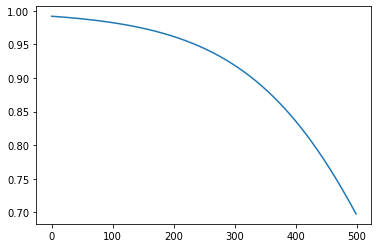

In [ ]:
x = np.arange(500)
y = list(map(inv_sigmoid_decay, x, [125]*500))
y = np.array(y)
plt.plot(x, y)

# 訓練

In [ ]:
import datetime
import os

model_name = datetime.datetime.now()
os.makedirs(str(model_name), exist_ok=True)
os.makedirs('{}/recon'.format(model_name), exist_ok=True)
with open('{}/param_{}.txt'.format(model_name, model_name), mode='w') as f:
    f.write(str(params))

In [ ]:
import pandas as pd
params['path'] = model_name
params['time'] = model_name
params_df = pd.read_csv('model_params.csv')
params_df = params_df.append(params, ignore_index=True)
params_df.to_csv('model_params.csv')

In [ ]:
class EarlyStopping:
    def __init__(self, name, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.name = name
    def __call__(self, loss):
        if self.best_score is None:
            self.best_score = loss
        elif self.best_score < loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = loss
            self.counter = 0
            torch.save(model.state_dict(), '{}/music_vae_{}.pth'.format(self.name, self.name))

In [ ]:
ls = np.arange(100, 0, -1)
es = EarlyStopping()
for l in ls:
    es(l)
    print(es.best_score, es.counter)
    if es.early_stop:
        break

In [ ]:
def recon_midi(x_sample, path):
    builder = MidiBuilder()
    row_maxes = x_sample.max(axis=1).reshape(-1, 1)
    midi_out = np.where(x_sample == row_maxes, 1, 0)
    if np.max(midi_out[:,:-1])==0:
        midi_out[:,:] = 1
    midi = builder.midi_from_piano_roll(midi_out[:,:-1])
    fig, ax = plt.subplots(figsize=(10, 3))
    builder.plot_midi(midi)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.savefig(path)
    #midi.write(path)
    return midi

In [16]:
num_epochs = 100
train_losses = []
valid_losses = []
early_stopping = EarlyStopping(model_name, patience=20)

for i in range(num_epochs):
    losses = []
    eps_i = ss_func(i, rate=125)#clamp(i, max=num_epochs)
    model.set_eps_i(eps_i)
    model.train()
    for input in train_loader:
        model.zero_grad()
        x = input['piano_rolls']
        x = x.float().to(device)
        y, loss, _ = model.forward(x)
        #print('i')
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().detach().numpy())
    train_losses.append(np.average(losses))

    with torch.no_grad():
        model.eval()
        losses = []
        for i_batch, input in enumerate(valid_loader):
            x = input['piano_rolls']
            x = x.float().to(device)
            y, loss, (recon, kl_d) = model.forward(x)
            losses.append(loss.cpu().detach().numpy())

            """
            if i%5 == 0 and i_batch == 0:
                x_sample = x.cpu().detach().numpy()
                y_sample = y.cpu().detach().numpy()
                
                for j in range(len(x_sample)):
                    recon_midi(x_sample[j], '{}/recon_learning/epoch:{}(original)'.format(model_name, i))
                    recon_midi(y_sample[j], '{}/recon_learning/epoch:{}(model)'.format(model_name, i))
                    break
            """     
        loss = np.average(losses)
        valid_losses.append(loss)
        print('epoch:{}\tloss:{}\ttest_loss:{}\trecon:{}\tkl_d:{}'.format(i, train_losses[-1], valid_losses[-1], recon, kl_d))
    
    early_stopping(valid_losses[-1])
    if early_stopping.early_stop:
        print('Early Stopping')
        break

epoch:0	loss:506.343017578125	test_loss:437.706298828125	recon:437.810546875	kl_d:0.7023195624351501
epoch:1	loss:373.72509765625	test_loss:344.7661437988281	recon:345.083740234375	kl_d:0.006533048581331968
epoch:2	loss:341.9496765136719	test_loss:337.8157958984375	recon:336.0926513671875	kl_d:0.0026124625001102686
epoch:3	loss:338.6444091796875	test_loss:336.9615478515625	recon:343.2529296875	kl_d:0.0015834980877116323
epoch:4	loss:337.87884521484375	test_loss:336.08148193359375	recon:335.138671875	kl_d:0.0011685049394145608
epoch:5	loss:336.96697998046875	test_loss:335.6476745605469	recon:331.91595458984375	kl_d:0.0009641158394515514
epoch:6	loss:336.38397216796875	test_loss:336.044921875	recon:342.76531982421875	kl_d:0.0007914715679362416
epoch:7	loss:335.9652404785156	test_loss:335.2829895019531	recon:331.514892578125	kl_d:0.0006573747959919274
epoch:8	loss:335.01416015625	test_loss:333.9814453125	recon:334.0360107421875	kl_d:0.000597759208176285
epoch:9	loss:332.2681884765625	test

# ロスが保存できなかった場合の応急処置

In [ ]:
with open('loss_0517_no cond.txt') as f:
    content = f.read()

In [ ]:
content = content.split('\n')#"replace('Early Stopping\n', '').split('\n')[:-1]
content

['epoch:0\tloss:297.3074645996094\ttest_loss:189.44261169433594\trecon:227.5342559814453\tkl_d:0.0018154194112867117',
 'epoch:1\tloss:80.328125\ttest_loss:17.525005340576172\trecon:12.606165885925293\tkl_d:0.0006592165445908904',
 'epoch:2\tloss:8.220298767089844\ttest_loss:3.7698323726654053\trecon:1.478340744972229\tkl_d:0.00046122889034450054',
 'epoch:3\tloss:2.268169403076172\ttest_loss:1.7329292297363281\trecon:0.45546603202819824\tkl_d:0.00018497489509172738',
 'epoch:4\tloss:1.0920311212539673\ttest_loss:1.9514245986938477\trecon:17.6158390045166\tkl_d:0.0002829215954989195',
 'epoch:5\tloss:0.6542097330093384\ttest_loss:0.7398308515548706\trecon:0.5155143737792969\tkl_d:0.00014885177370160818',
 'epoch:6\tloss:0.44151073694229126\ttest_loss:0.5307603478431702\trecon:0.23584207892417908\tkl_d:0.00010852922423509881',
 'epoch:7\tloss:0.3264042139053345\ttest_loss:0.38536491990089417\trecon:0.15857744216918945\tkl_d:9.383667929796502e-05',
 'epoch:8\tloss:0.24165746569633484\tte

In [ ]:
import re
test = 'aloss:1.2 test_loss:5.5 zz'
pattern = '.*loss:([\d\.]+).*test_loss:([\d\.]+).*'
rep = re.compile(pattern)

In [ ]:
test = '\t\tepoch:344\tloss:117.62822723388672\ttest_loss:127.13897705078125\trecon:87.85936737060547\tkl_d:5.445697297545848e-07'
rep.match(test).group(2)

'127.13897705078125'

In [ ]:
train_losses = []
valid_losses = []

for line in content:
    result = rep.match(line)
    train_losses.append(float(result.group(1)))
    valid_losses.append(float(result.group(2)))

# ロス・モデルの保存

In [17]:
np.save('{}/train_losses_{}.npy'.format(model_name, model_name), np.array(train_losses))
np.save('{}/valid_losses_{}.npy'.format(model_name, model_name), np.array(valid_losses))

In [ ]:
with open('param_{}.txt'.format(model_name), mode='w') as f:
    f.write(str(params))

In [ ]:
test_losses = np.load('train_losses_{}.npy'.format('0511'))
train_losses = np.load('test_losses_{}.npy'.format('0511'))

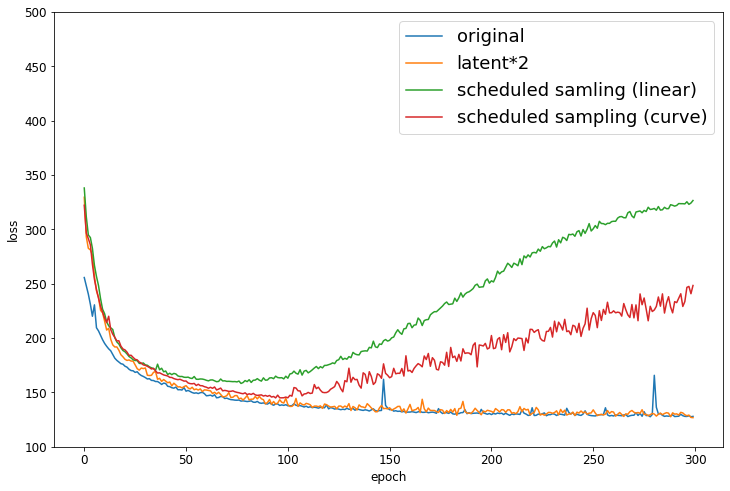

In [ ]:
import matplotlib.pyplot as plt

lim = 300
loss_h = np.load('test_losses_0511.npy')[:lim]
loss_2h = np.load('test_losses_0517.npy')[:lim]
loss_inv_sig = np.load('test_losses_0516_invsig.npy')[:lim]
loss_clamp = np.load('test_losses_0516_clamp.npy')[:lim]

plt.figure(figsize=(12,8))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(loss_h, label='original')
plt.plot(loss_2h, label='latent*2')
plt.plot(loss_inv_sig, label='scheduled samling (linear)')
plt.plot(loss_clamp, label='scheduled sampling (curve)')
plt.ylim(100, 500)
plt.legend(fontsize=18)

In [ ]:
torch.save(model.state_dict(), '{}/music_vae_{}_studied2.pth'.format(model_name, model_name))

In [ ]:
model_name = '2022-05-21 09:08:08.257377'

In [ ]:
model = MusicVAE(params, device).to(device)
params['model'] = str(model)
model.load_state_dict(torch.load('{}/music_vae_{}_studied2.pth'.format(model_name, model_name)))
optimizer = optim.Adam(model.parameters(), lr=0.001)
ss_func = always_one

In [ ]:
model.state_dict()

OrderedDict([('enc_lstm.weight_ih_l0',
              tensor([[-0.2320, -0.1112, -0.2007,  ..., -0.0254,  0.0309, -0.2392],
                      [-0.1667, -0.1537, -0.1197,  ...,  0.0102,  0.0081, -0.2659],
                      [-0.1842, -0.0791, -0.1567,  ...,  0.0294,  0.0087, -0.4060],
                      ...,
                      [-0.2096, -0.1285, -0.1731,  ..., -0.0276,  0.0239, -0.1977],
                      [-0.1993, -0.1662, -0.1167,  ..., -0.0179,  0.0301, -0.3010],
                      [-0.1536, -0.1178, -0.1863,  ...,  0.0230, -0.0381, -0.4595]],
                     device='cuda:0')),
             ('enc_lstm.weight_hh_l0',
              tensor([[ 0.0063,  0.0145,  0.0160,  ...,  0.0492, -0.0165, -0.0089],
                      [-0.0054,  0.0476, -0.0246,  ..., -0.0042, -0.0515,  0.0268],
                      [ 0.0234,  0.0147, -0.0391,  ...,  0.0100, -0.0325,  0.0090],
                      ...,
                      [-0.0093, -0.0095, -0.0557,  ...,  0.0085, -0.007

# モデルの評価

In [ ]:
def calc_accuracy(x, x_p):
    idx = np.argmax(x, axis=-1)
    idx_p = np.argmax(x_p, axis=-1)
    return np.mean(idx==idx_p)

In [ ]:
model.set_eps_i(eps_i)

In [ ]:
model.zero_grad()
best_acc = 0
with torch.no_grad():
    model.eval()
    for x in valid_loader:
        x = x['piano_rolls']
        x = x.float().to(device)
        y, loss, _ = model.forward(x)
        print(loss)

        x_sample = x.cpu().detach().numpy()
        y_sample = y.cpu().detach().numpy()

        acc = calc_accuracy(x_sample, y_sample)
        if acc > best_acc:
            best_acc = acc
            x_best = x_sample
            y_best = y_sample

tensor(132.5350, device='cuda:0')
tensor(130.6560, device='cuda:0')
tensor(143.5839, device='cuda:0')
tensor(141.9084, device='cuda:0')
tensor(137.3270, device='cuda:0')
tensor(125.3053, device='cuda:0')
tensor(153.7928, device='cuda:0')
tensor(125.8628, device='cuda:0')
tensor(159.9374, device='cuda:0')
tensor(136.6640, device='cuda:0')
tensor(138.7681, device='cuda:0')
tensor(141.7003, device='cuda:0')
tensor(152.7504, device='cuda:0')
tensor(132.8567, device='cuda:0')
tensor(128.8349, device='cuda:0')
tensor(119.6302, device='cuda:0')


In [ ]:
calc_accuracy(x_sample, y_sample)

0.39417613636363635

/usr/local/lib/python3.7/dist-packages/librosa/display.py:1336: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  "Frequency axis exceeds Nyquist. "


1
2
3
4
5


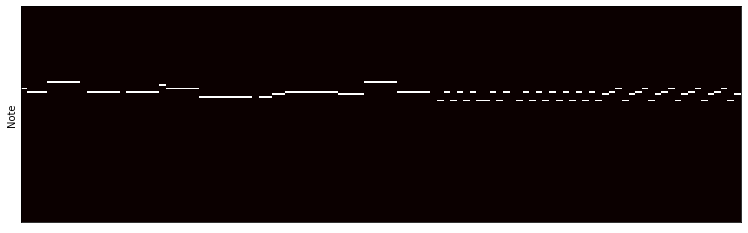

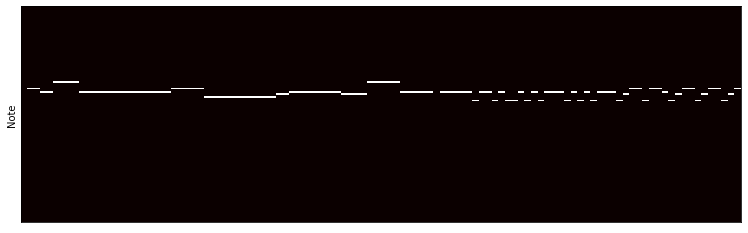

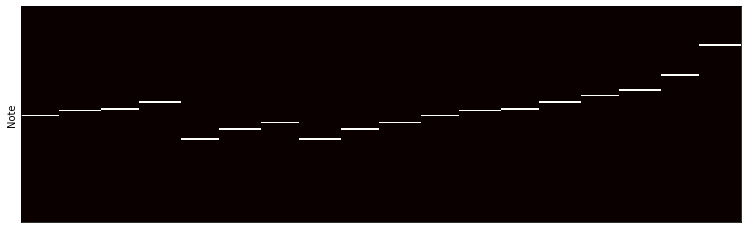

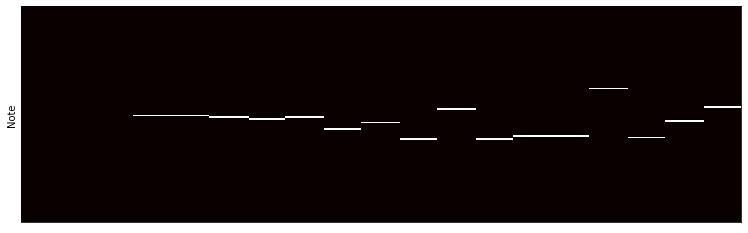

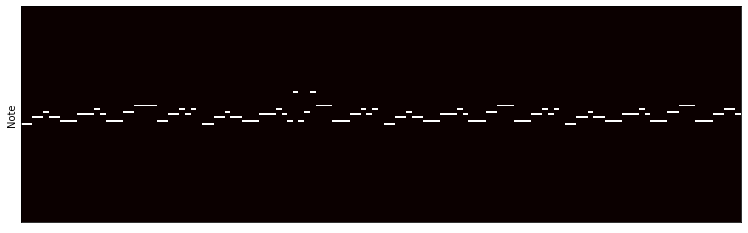

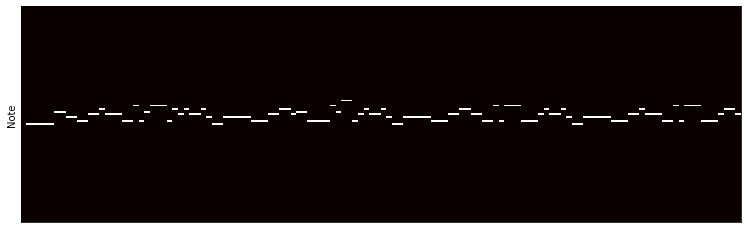

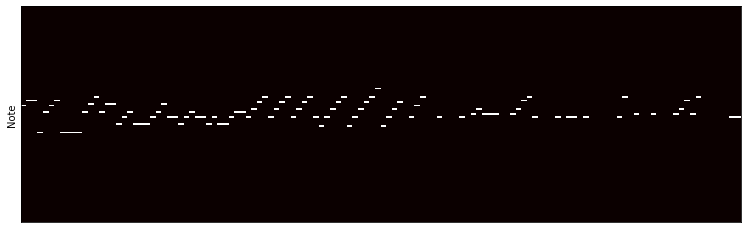

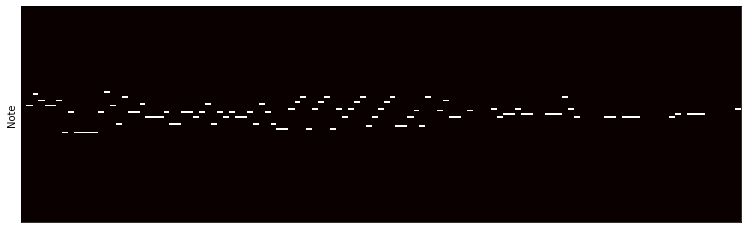

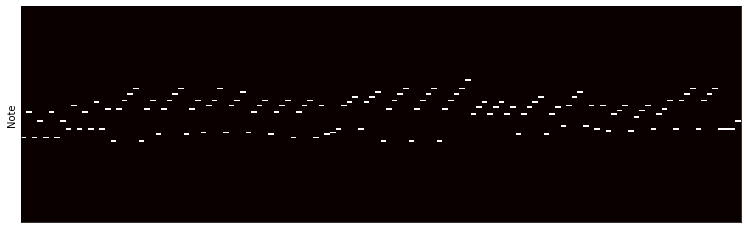

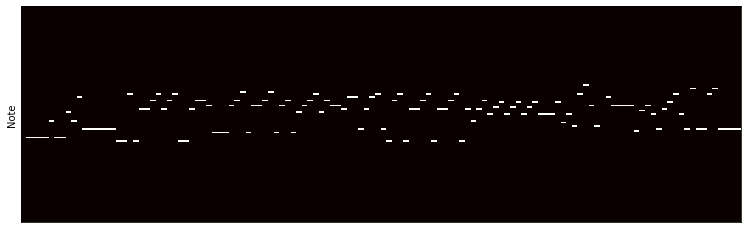

In [ ]:
cnt = 0
while cnt<5:
    midi1 = recon_midi(x_best[cnt], 'recon/recon({})(original_{}).png'.format(cnt, model_name))
    midi1.write('recon/recon({})(original).mid'.format(cnt))
    midi2 = recon_midi(y_best[cnt], 'recon/recon({})(model_{}).png'.format(cnt, model_name))
    midi2.write('recon/recon({})(model).mid'.format(cnt))
    cnt += 1
    print(cnt)

/usr/local/lib/python3.7/dist-packages/librosa/display.py:1336: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  "Frequency axis exceeds Nyquist. "


'\nbuilder = MidiBuilder()\nmidi = builder.midi_from_piano_roll(x_sample[:,:-1])\nplt.figure(figsize=(10,3))\nbuilder.plot_midi(midi)\n'

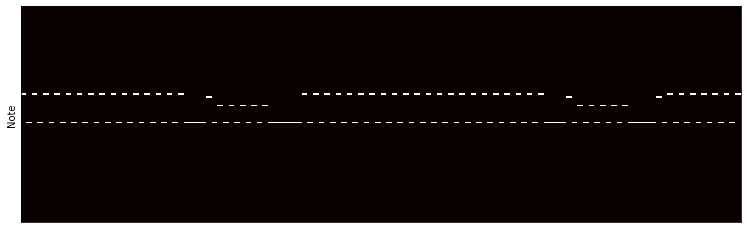

In [ ]:
for _x in test_loader:
    x = _x['piano_rolls'][0].to(device)
    break
x_sample = x.cpu().detach().numpy()

recon_midi(x_sample, 'test_t')
# TODO: オール0を除外
"""
builder = MidiBuilder()
midi = builder.midi_from_piano_roll(x_sample[:,:-1])
plt.figure(figsize=(10,3))
builder.plot_midi(midi)
"""

# 潜在空間の可視化

In [ ]:
model.eval()
zs = []
for x in valid_loader:
    x = x['piano_rolls'].float().to(device)
    y = model.forward(x)

    model.z

AttributeError: ignored